In [1]:
import torch
from torch import nn
from src.data.make_cifar10_dataset import CIFAR10, get_img_transformer
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.cifar10_conv_model import Cifar10ConvModel
from sklearn import metrics
import numpy as np
import torch.nn.functional as nnf
from skimage import io
from src.models.conformal_model import ConformalModel, ConformalModelLogits
from src.utils.cp_utils import *

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
test_dataset = CIFAR10(split="test", root='../data/processed', download=True,
                      transform=get_img_transformer())
test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32)

n_classes = len(set(test_dataset.targets))
classes = {index: name for name, index in test_dataset.class_to_idx.items()}


Files already downloaded and verified


In [3]:
model = Cifar10ConvModel()
model.load_state_dict(torch.load("../models/trained_model.pt"))
criterion = nn.CrossEntropyLoss()
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())


In [23]:
correct = 0
total = 0
f1score = AverageMeter('f1score')
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        batch_f1_score, _, _ = get_metrics_score(
    output, targets)
        f1score.update(batch_f1_score, inputs.shape[0])
        predictions = output.max(1)[1]
        total += targets.size(0)
        correct += (predictions == targets).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %, F1: {f1score.avg}')
    model.train()
# confusion_matrix = np.zeros((n_classes, n_classes))
# with torch.no_grad():
#     model.eval()
#     test_accuracies = []
#     for inputs, targets in test_dataloader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         output = model(inputs)
#         loss = criterion(output, targets)
#         predictions = output.max(1)[1]
#         test_accuracies.append(accuracy(targets, predictions) * len(inputs))
#     test_accuracy = np.sum(test_accuracies) / len(test_dataset)
#     model.train()

Accuracy of the network on the 10000 test images: 65 %, F1: 0.6028353315459525


## Test augmented dataset


In [14]:

def get_aug_img_transformer():
    return transforms.Compose([
        # transforms.ToTensor(),
        transforms.AugMix(severity=6, chain_depth=6),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
aug_test_dataset = torchvision.datasets.CIFAR10(train=False, root='../data/processed', download=True,
                      transform=get_aug_img_transformer())
aug_testloader = torch.utils.data.DataLoader(aug_test_dataset,
                                              batch_size=32,
                                              shuffle=True)

Files already downloaded and verified


In [15]:

premodel = Cifar10ConvModel().cpu()
premodel.load_state_dict(torch.load("../models/trained_model.pt"))
calib_dataset  = CIFAR10(split="calib", root='../data/processed', download=True,
                      transform=get_img_transformer())
calib_loader  = torch.utils.data.DataLoader(
        calib_dataset, batch_size=32)
conf_model = ConformalModel(model=premodel,calib_loader=calib_loader, alpha=0.05)


Files already downloaded and verified
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 313/313 [00:03<00:00, 93.09it/s]


Optimal T=1.2102073431015015


In [22]:
validate(test_dataloader, conf_model, True)

N: 10000 | Time: 0.011 (0.013) | Cvg@1: 0.875 (0.653) | Cvg@5: 1.000 (0.966) | F1: 0.603 | Cvg@RAPS: 1.000 (0.961) | Size@RAPS: 3.625 (3.829)


(0.6535, 0.9659, 0.6028353315459525, 0.9609, 3.8292)

In [17]:
with torch.no_grad():
    model.eval()
    f1score = AverageMeter('f1score')
    test_accuracies = []
    for inputs, targets in aug_testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        batch_f1_score, _, _ = get_metrics_score(
    output, targets)
        f1score.update(batch_f1_score, inputs.shape[0])
        predictions = output.max(1)[1]
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(test_dataset)
    
    model.train()

In [18]:
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"F1: {f1score.avg}")

Test accuracy: 0.521
F1: 0.4775886537354401


In [ ]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

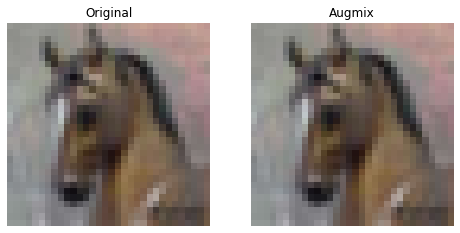

In [29]:
i=210
# plt.imshow(aug_test_dataset.data[i])
# plt.imshow(test_dataset.data[i])

show_comparison(test_dataset.data[i], aug_test_dataset.data[i], 'Augmix')

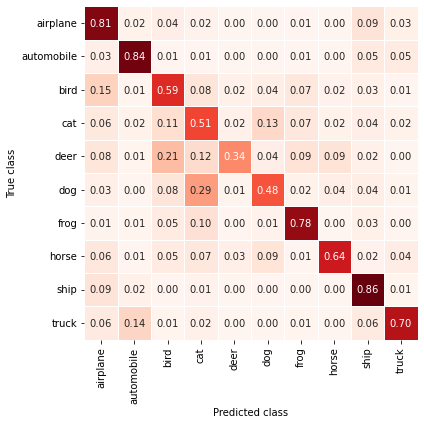

In [225]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

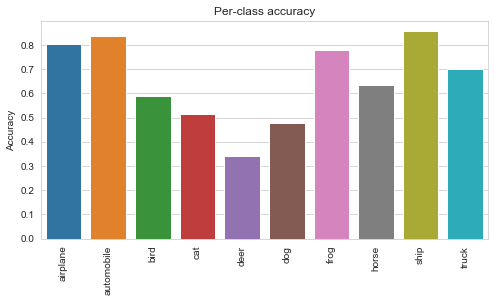

In [226]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

## Adaprive pred sets

In [3]:
calib_dataset = CIFAR10(split="calib", root='../data/processed', download=True,
                      transform=get_img_transformer())
calib_dataloader = torch.utils.data.DataLoader(
        calib_dataset, batch_size=128)

Files already downloaded and verified


In [248]:
# get prob from calib set
n=len(test_dataset)
cal_lis = []
cal_labels = []
with torch.no_grad():
    model.eval()
    for inputs, targets in calib_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        prob = nnf.softmax(output, dim=1)
        cal_labels.append(targets)
        cal_lis.append(prob)
    model.train()
cal_labels= np.concatenate(cal_labels, axis=0)
cal_smx = np.concatenate(cal_lis, axis=0)
# cal_scores = 1-cal_smx[np.arange(n), true_calib_class]

In [229]:
# getting the prob from test set
val_lis = []
true_test_class = []
with torch.no_grad():
    model.eval()
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        prob = nnf.softmax(output, dim=1)
        val_lis.append(prob)
        true_test_class.append(targets)
    model.train()
true_test_class= np.concatenate(true_test_class, axis=0)
val_smx = np.concatenate(val_lis, axis=0)

In [254]:
# alpha=0.05
# get the index of descending sorted prob 
cal_pi = cal_smx.argsort(1)[:,::-1]
# use indices to sort and sum probabilities
cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),cal_labels]
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)

/var/folders/dw/gf2x93p50fdd3796cx4grnqw0000gn/T/ipykernel_19135/3687515837.py:7: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


In [260]:
asp_pred_set_length = []
n_target_in_pred_set = 0
for idx, p_set in enumerate(prediction_sets):
    print(p_set)
    asp_pred_set_length.append(len(p_set[p_set==True]))
    pred_set_classes = np.array(p_set == True).nonzero()[0]
    print(f"predicted classes: {pred_set_classes}")
    is_target_in_pred_set = true_test_class[idx] in pred_set_classes
    if is_target_in_pred_set: 
        n_target_in_pred_set+=1
    print(f"true class in pred set: {is_target_in_pred_set}")
    print(val_smx[idx])
    print(f"true class: {true_test_class[idx]}")
    print("\n")
    # break

[False  True  True  True  True  True  True  True  True  True]
predicted classes: [1 2 3 4 5 6 7 8 9]
true class in pred set: True
[0.0039889  0.00667356 0.0243001  0.7000196  0.01658953 0.11909725
 0.09662572 0.00865696 0.01541254 0.00863574]
true class: 3


[ True False False False False False False False  True False]
predicted classes: [0 8]
true class in pred set: True
[2.2949906e-02 4.0836111e-03 2.6609778e-05 1.4968144e-05 2.5612835e-05
 5.2471540e-07 5.2386067e-06 4.2381856e-07 9.7202998e-01 8.6314406e-04]
true class: 8


[ True  True  True  True  True False False  True  True  True]
predicted classes: [0 1 2 3 4 7 8 9]
true class in pred set: True
[0.29236004 0.0238635  0.00870633 0.0028456  0.01032543 0.00081809
 0.00121009 0.00190505 0.61142975 0.04653611]
true class: 8


[ True  True  True False  True False False False  True  True]
predicted classes: [0 1 2 4 8 9]
true class in pred set: True
[6.9666588e-01 2.6643237e-03 1.4269770e-02 8.9254050e-04 1.0185300e-02
 1.3624519e-04

In [11]:
def get_dataset_smx_scores(set_type):
    data_loader = calib_dataloader if set_type == "calib" else test_dataloader
    prob_list = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            prob = nnf.softmax(output, dim=1)
            prob_list.append(prob)
        model.train()
    return np.concatenate(prob_list, axis=0)

In [19]:
def get_adaptive_predition_set(alpha):
    cal_smx = get_dataset_smx_scores("calib")
    val_smx = get_dataset_smx_scores("test")
    n=len(calib_dataset.targets)
    # get the index of descending sorted prob 
    cal_pi = cal_smx.argsort(1)[:,::-1]
    # use indices to sort and sum probabilities
    cal_srt = np.take_along_axis(cal_smx,cal_pi,axis=1).cumsum(axis=1)
    cal_scores = np.take_along_axis(cal_srt,cal_pi.argsort(axis=1),axis=1)[range(n),calib_dataset.targets]
    qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    # Deploy (output=list of length n, each element is tensor of classes)
    val_pi = val_smx.argsort(1)[:,::-1]; val_srt = np.take_along_axis(val_smx,val_pi,axis=1).cumsum(axis=1)
    prediction_sets = np.take_along_axis(val_srt <= qhat,val_pi.argsort(axis=1),axis=1)
    return prediction_sets

/var/folders/dw/gf2x93p50fdd3796cx4grnqw0000gn/T/ipykernel_41411/4036949097.py:10: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


[0.9528, 0.9039, 0.8526, 0.8026]

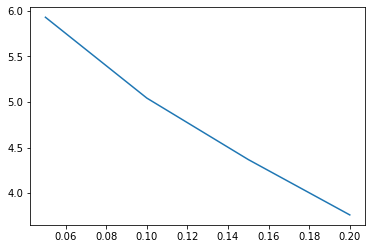

In [37]:
alpha_list = [0.05, 0.1, 0.15, 0.2]
avg_set_size=[]
coverage_list = []
for alpha in alpha_list:
    asp_pred_set_length = []
    n_target_in_pred_set = 0
    for idx, p_set in enumerate(get_adaptive_predition_set(alpha)):
        asp_pred_set_length.append(len(p_set[p_set==True]))
        pred_set_classes = np.array(p_set == True).nonzero()[0]
        is_target_in_pred_set = test_dataset.targets[idx] in pred_set_classes
        if is_target_in_pred_set: 
            n_target_in_pred_set+=1
    avg_set_size.append(np.mean(asp_pred_set_length))
    coverage_list.append(n_target_in_pred_set/ len(test_dataset))

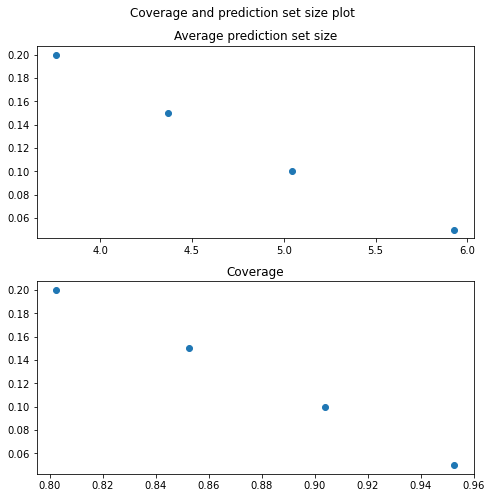

In [60]:

fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))
fig.suptitle('Coverage and prediction set size plot')
ax1.plot(avg_set_size,alpha_list,'o')
ax1.set_title("Average prediction set size")

ax2.plot(coverage_list,alpha_list,'o')
ax2.set_title("Coverage")
fig.tight_layout(pad=1.0)
plt.show()